## Grad-CAM official example

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
#model_builder = keras.applications.xception.Xception
model_builder = tf.keras.applications.MobileNet
#img_size = (299, 299)
img_size = (244, 244)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"
last_conv_layer_name = "conv_preds"

## The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
# )


In [7]:
working_folder = '/home/rt2776/cnv_espresso/project7_spark_wes3_wes_wgs/05b_xhmm_CNVEspresso/images/' 
img_path = working_folder + '12660_SP0172810_18_14523463_14524983_NAtgs_2wins_DEL.png'

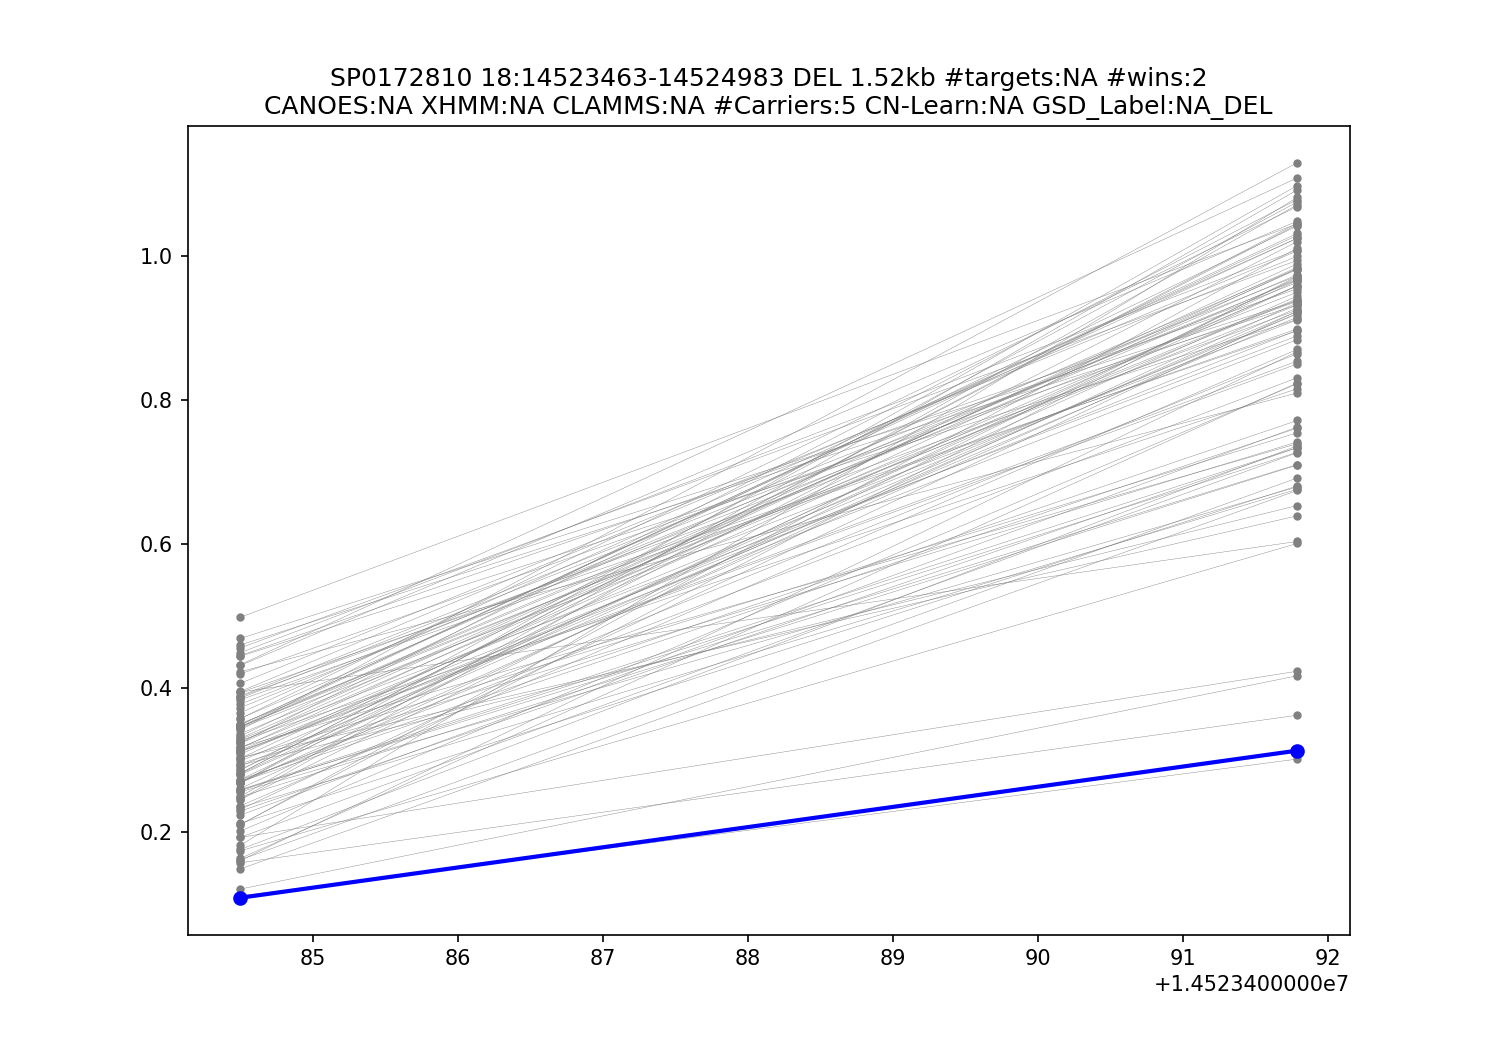

In [8]:
display(Image(img_path))

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

Predicted: [('n06359193', 'web_site', 7.434134)]


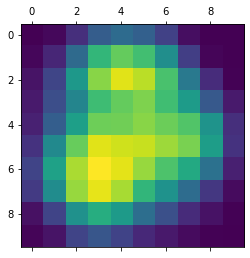

In [183]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

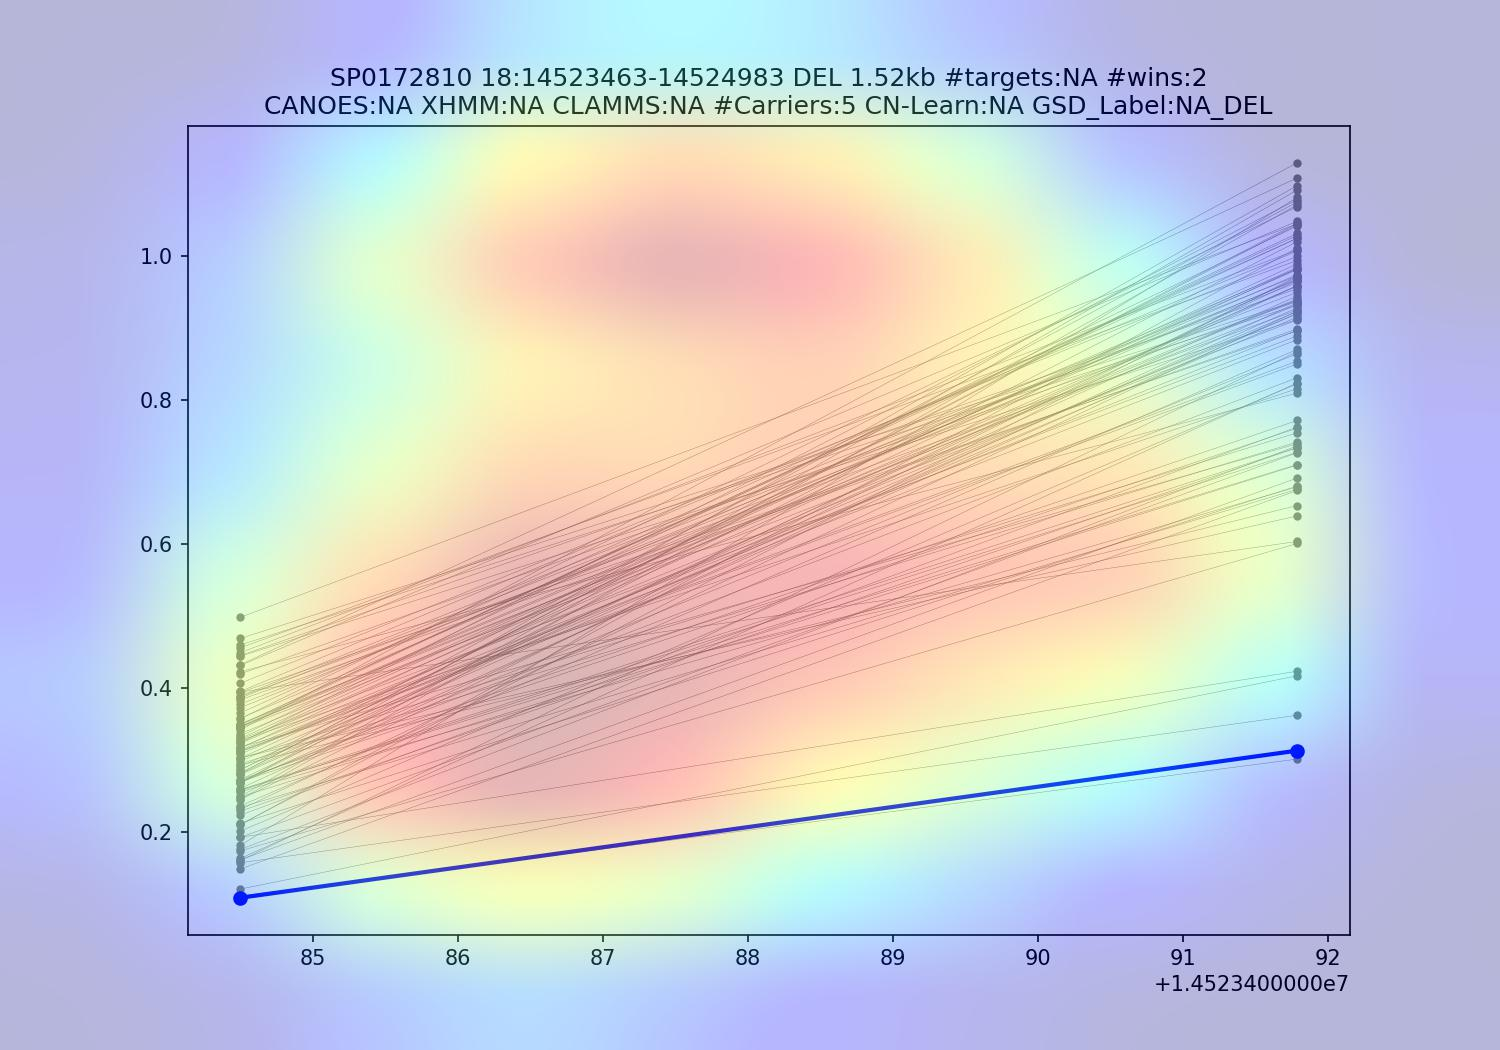

In [24]:
save_and_display_gradcam(img_path, heatmap)

## Try with my model

In [21]:
import sys
sys.path.append('/home/rt2776/cnv_espresso/src')
import function_dl as func_dl
import function as func

model_file = '/home/rt2776/cnv_espresso/model/MobileNet_v1_fine-tuning_3classes_log_transformed.h5'
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}

cnv_espresso_model = keras.models.load_model(model_file, custom_objects=custom_objects)

Tensorflow version 2.2.0


In [22]:
cnv_espresso_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [23]:
model_builder = tf.keras.applications.MobileNet
model = model_builder(weights="imagenet")

In [24]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [18]:
## debug step by step by RT

last_conv_layer_name = "conv_pw_13"

# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions

grad_model = tf.keras.models.Model(cnv_espresso_model.layers[1].get_layer("input_4").input,
                      cnv_espresso_model.layers[1].get_layer("conv_pw_13").output,
                      cnv_espresso_model.output
)

NameError: name 'cnv_espresso_model' is not defined

In [199]:
def make_gradcam_heatmap(img_array, cnv_espresso_model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(cnv_espresso_model.layers[1].get_layer("input_4").input,
                      cnv_espresso_model.layers[1].get_layer("conv_pw_13").output,
                      cnv_espresso_model.output)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [203]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
# model = model_builder(weights="imagenet")

In [217]:

cnv_espresso_model.layers[-1].activation = None

In [218]:
grad_model = tf.keras.models.Model(cnv_espresso_model.layers[1].get_layer("input_4").input,
                      cnv_espresso_model.layers[1].get_layer("conv_pw_13").output,
                      cnv_espresso_model.output)

In [219]:
grad_model(img_array)

NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.

In [102]:
for layer in cnv_espresso_model.layers[0:]:
    print(layer.name)

input_5
mobilenet_1.00_224
global_average_pooling2d_2
dense_3


In [48]:
# Remove last layer's softmax
cnv_espresso_model.layers[-1].activation = None

# Print what the top predicted class is
preds = cnv_espresso_model.predict(img_array)
preds

array([[0.76748234, 0.22936621, 0.00315147]], dtype=float32)

In [60]:
cnv_espresso_model.get_layer("global_average_pooling2d_2")

In [116]:
pred_index=None

# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
grad_model = tf.keras.models.Model(
    [cnv_espresso_model.inputs], 
    [cnv_espresso_model.layers[1].get_layer("conv_pw_13").output, cnv_espresso_model.output]
)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_4_1:0", shape=(None, 224, 224, 3), dtype=float32) at layer "input_4". The following previous layers were accessed without issue: []

In [56]:
grad_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:

    


# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
return heatmap.numpy()

In [52]:
# Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = make_gradcam_heatmap(img_array, cnv_espresso_model, last_conv_layer_name)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_4_1:0", shape=(None, 224, 224, 3), dtype=float32) at layer "input_4". The following previous layers were accessed without issue: []

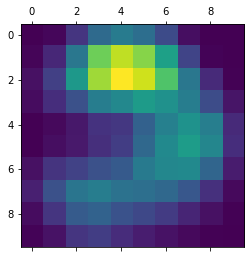

In [50]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

Reference:
- https://keras.io/examples/vision/grad_cam/